In [1]:
from IPython.display import display, HTML

# Create the HTML code for the styled title
html_code = """
<div style="text-align: center; font-size: 30px; font-weight: light;">
    <div style="color: #E74C3C;">DSCI-6011-04</div> <!-- Red Color -->
    <div style="color: #F1C40F;">Deep Learning Final Project Code</div> <!-- Yellow Color -->
    <div style="color: #2E86C1;">University of New Haven</div> <!-- Blue Color with Underline -->
</div>
"""

# Display the HTML code in the notebook
display(HTML(html_code))

# Data Aquisition

In [2]:
import json
import csv

def jsonl_to_csv(jsonl_file, csv_file):
    """
    Converts a JSONL file to a CSV file.

    Args:
    - jsonl_file (str): Path to the JSONL file.
    - csv_file (str): Path to the output CSV file.
    """
    try:
        with open(jsonl_file, 'r', encoding='utf-8') as infile, open(csv_file, 'w', newline='', encoding='utf-8') as outfile:
            # Read the first JSON object to get fieldnames for the CSV
            first_line = json.loads(infile.readline().strip())
            fieldnames = list(first_line.keys())

            # Write the CSV headers
            writer = csv.DictWriter(outfile, fieldnames=fieldnames)
            writer.writeheader()

            # Write the first line and process the rest
            writer.writerow(first_line)
            for line in infile:
                writer.writerow(json.loads(line.strip()))

        print(f"Conversion completed. CSV file saved at: {csv_file}")
    except Exception as e:
        print(f"An error occurred: {e}")

# File paths
jsonl_file = '/content/Appliances.jsonl'  # Input JSONL file path
csv_file = '/content/Appliances.csv'     # Output CSV file path

# Convert the JSONL file to CSV
jsonl_to_csv(jsonl_file, csv_file)


Conversion completed. CSV file saved at: /content/Appliances.csv


In [3]:
import pandas as pd

df = pd.read_csv(csv_file)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2128605 entries, 0 to 2128604
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   rating             float64
 1   title              object 
 2   text               object 
 3   images             object 
 4   asin               object 
 5   parent_asin        object 
 6   user_id            object 
 7   timestamp          int64  
 8   helpful_vote       int64  
 9   verified_purchase  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 148.2+ MB


In [4]:
df.head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Work great,work great. use a new one every month,[],B01N0TQ0OH,B01N0TQ0OH,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1519317108692,0,True
1,5.0,excellent product,Little on the thin side,[],B07DD2DMXB,B07DD37QPZ,AHWWLSPCJMALVHDDVSUGICL6RUCA,1664746863446,0,True
2,5.0,Happy customer!,"Quick delivery, fixed the issue!",[],B082W3Z9YK,B082W3Z9YK,AHZIJGKEWRTAEOZ673G5B3SNXEGQ,1607225435363,0,True
3,5.0,Amazing value,I wasn't sure whether these were worth it or n...,[],B078W2BJY8,B078W2BJY8,AFGUPTDFAWOHHL4LZDV27ERDNOYQ,1534104184306,0,True
4,5.0,Dryer parts,Easy to install got the product expected to re...,[],B08C9LPCQV,B08C9LPCQV,AELFJFAXQERUSMTXJQ6SYFFRDWMA,1620176603754,0,True


# Data Cleaning

In [5]:
# Removing null values and dropping duplicates
df = df.dropna().drop_duplicates()

# Checking if nulls are removed
null_count = df.isnull().sum()

print("Current data shape is: ", df.shape)

Current data shape is:  (2104493, 10)


Taking a sample of our dataset for fast-computaion.

In [6]:
df = df.copy().iloc[0:100000] # First 100K rows

# Dropping unnecessary columns (updated to reflect the new structure)
df = df.drop(['asin', 'parent_asin', 'user_id', 'timestamp', 'images','verified_purchase', 'helpful_vote', 'rating'], axis=1)

# Displaying the DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 100370
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   100000 non-null  object
 1   text    100000 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


# Tokenization & Data Pre-processing

In [7]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
dff = df.copy()

# Remove rows with missing values in the 'text' column
dff = dff.dropna(subset=['text'])

Stop-word visualizating

In [9]:
# Extract stopwords from the text column
def extract_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    return [word for word in words if word in stop_words]

# Apply the function to extract stopwords
dff['stopwords'] = dff['text'].apply(lambda x: extract_stopwords(str(x)) if isinstance(x, str) else [])

# Flatten the list of stopwords
all_stopwords = [word for sublist in dff['stopwords'] for word in sublist]

# Visualize stopwords using a frequency plot
stopword_counts = Counter(all_stopwords)
most_common_stopwords = stopword_counts.most_common(50)  # Top 50 most common stopwords


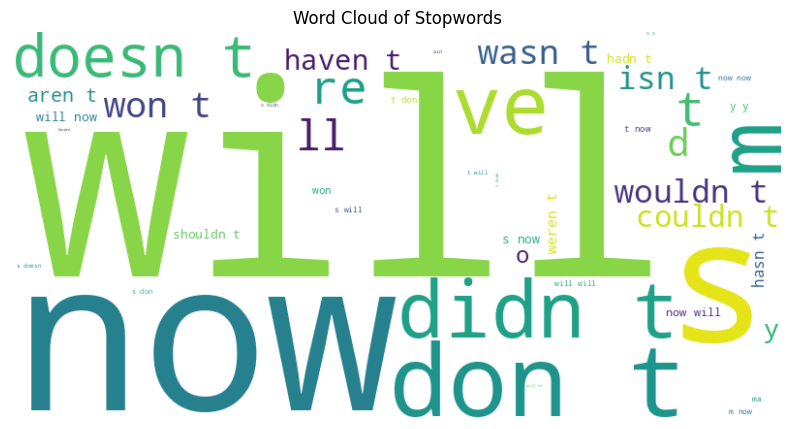

In [10]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_stopwords))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Stopwords')
plt.show()

In [11]:
# Step 2: Clean the Text with Stemming, Lemmatization
def clean_text(text, use_lemmatization=True, correct_spelling=True):
    """
    Function to clean text:
    - Converts to lowercase
    - Removes special characters, digits, and extra spaces
    - Tokenizes the text
    - Applies stemming or lemmatization
    """
    # Convert text to lowercase
    text = text.lower()

    # Remove special characters (excluding digits) and extra spaces
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Keeps digits (0-9)
    text = re.sub(r'\s+', ' ', text).strip()  # Removes extra spaces

    # Tokenize the text
    tokens = word_tokenize(text)

    # Optionally remove stopwords (common in text preprocessing)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Apply stemming or lemmatization
    if use_lemmatization:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    else:
        tokens = [stemmer.stem(word) for word in tokens]

    return tokens



In [12]:
# Example: Apply the function to the 'text' column of the `dff` dataframe
dff['cleaned_text'] = dff['text'].apply(lambda x: clean_text(str(x), use_lemmatization=True) if isinstance(x, str) else [])

# Display the cleaned text column
dff[['text', 'cleaned_text']].head(5)

,text,cleaned_text
0,work great. use a new one every month,"[work, great, use, new, one, every, month]"
1,Little on the thin side,"[little, thin, side]"
2,"Quick delivery, fixed the issue!","[quick, delivery, fixed, issue]"
3,I wasn't sure whether these were worth it or n...,"[wasnt, sure, whether, worth, given, cost, com..."
4,Easy to install got the product expected to re...,"[easy, install, got, product, expected, receive]"


In [13]:
dff.drop(['stopwords','title','text'], axis=1, inplace=True)

dff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 100370
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   cleaned_text  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


In [14]:
dff.head(10)

,cleaned_text
0,"[work, great, use, new, one, every, month]"
1,"[little, thin, side]"
2,"[quick, delivery, fixed, issue]"
3,"[wasnt, sure, whether, worth, given, cost, com..."
4,"[easy, install, got, product, expected, receive]"
5,"[buying, ice, machine, 15, month, ago, using, ..."
6,"[best, quality]"
7,"[part, came, quickly, fit, lg, dryer, thanks]"
8,"[always, arrive, fast, manner, description, li..."
9,"[company, responded, quickly, refunded, purcha..."


In [15]:
# Calculate the length of each list in the 'cleaned_text' column
dff['text_length'] = dff['cleaned_text'].apply(len)

# Get the maximum and minimum lengths
max_length = dff['text_length'].max()
min_length = dff['text_length'].min()

print("Maximum length:", max_length)
print("Minimum length:", min_length)

# Remove rows with more than 100 words
df_filtered = dff[dff['text_length'] <= 100]

# Check the shape of the filtered DataFrame
print("Shape of filtered DataFrame:", df_filtered.shape)

Maximum length: 1483
Minimum length: 0
Shape of filtered DataFrame: (97698, 2)


In [16]:
df_filtered.drop('text_length', axis=1, inplace=True)

<ipython-input-16-305764e680d1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop('text_length', axis=1, inplace=True)


In [17]:
df_filtered.head(5)

,cleaned_text
0,"[work, great, use, new, one, every, month]"
1,"[little, thin, side]"
2,"[quick, delivery, fixed, issue]"
3,"[wasnt, sure, whether, worth, given, cost, com..."
4,"[easy, install, got, product, expected, receive]"


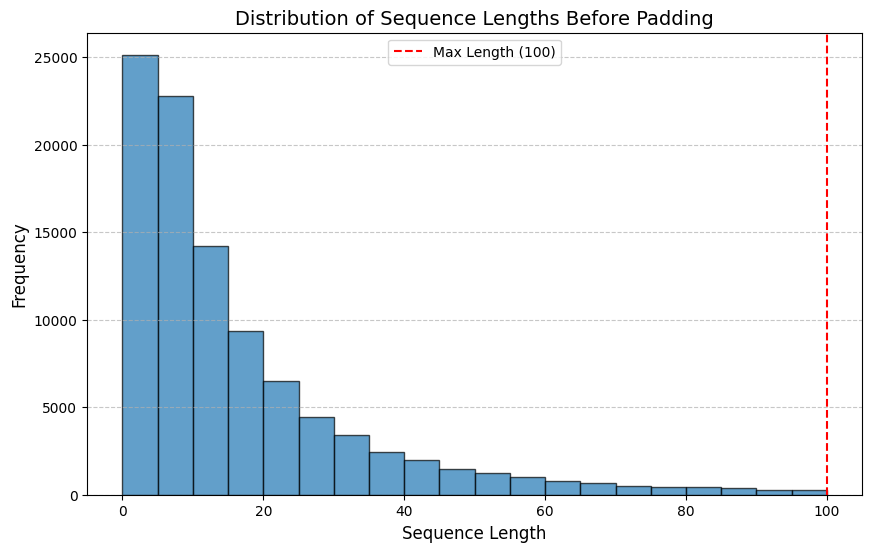

In [18]:
# Calculate sequence lengths
sequence_lengths = [len(text) for text in df_filtered['cleaned_text']]

# Plot histogram of sequence lengths
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=np.arange(0, max(sequence_lengths) + 5, 5), edgecolor='k', alpha=0.7)
plt.axvline(x=100, color='r', linestyle='--', label='Max Length (100)')
plt.title('Distribution of Sequence Lengths Before Padding', fontsize=14)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Annotate Dataset with RegEx

In [19]:
dff = df_filtered.copy()

In [20]:
# Define categories and their expanded patterns
regex_patterns = {
    "Usability": r"(easy|install|setup|use|interface|clean|replace|fit|work|adjust|fast|convenient|comfortable|functional|practical|assembly|instructions|filter|work|one|great|coffee|water|fit|use|easy|br|like|good|ice|well|get|time|make|would|product|machine)",
    "Price": r"(price|cost|expensive|cheap|worth|value|deal|budget|affordable|savings|premium|low-cost|reasonable|price|part|perfect|cup|dont|much|clean|dryer|little|install|love|new|really|need|perfectly|year|buy|replacement|used|im)",
    "Quality": r"(quality|durable|material|build|standard|sturdy|broken|thin|great|strong|lasting|fragile|cheaply-made|superior|perfect|poor|premium|using|bought|better|old|also|small|keep|washer|made|maker|thing|put|back|fridge|even|look|problem|refrigerator|top|two)",
    "Customer Service": r"(support|service|customer|help|response|refund|replace|company|problem|satisfaction|complaint|resolved|recommend|returns|way|worked|fine|first|original|still|stove|right|2|got|month|nice|quality|ground|needed|taste|didnt|come|go|day)",
    "Delivery": r"(delivery|shipping|arrive|fast|late|packaging|received|quick|prime|delay|tracking|on-time|packed|order|dispatch|take|size|ive|dishwasher|replace|sure|item|recommend|could|doesnt|plastic|last|lot|brand|long|money|came|unit|door|issue)"
}

In [21]:
dff.shape

(97698, 1)

Using the cleaned_text column to assign categories based on predefined regex patterns.

In [22]:
# Function to tag categories
def tag_categories(text, patterns):
    tags = []
    for category, pattern in patterns.items():
        if any(re.search(pattern, word, re.IGNORECASE) for word in text):
            tags.append(category)
    return tags

# Apply tagging function
dff['categories'] = dff['cleaned_text'].apply(lambda x: tag_categories(x, regex_patterns))


In [23]:
print(dff[['cleaned_text', 'categories']].head(10))

                                        cleaned_text  \
0         [work, great, use, new, one, every, month]   
1                               [little, thin, side]   
2                    [quick, delivery, fixed, issue]   
3  [wasnt, sure, whether, worth, given, cost, com...   
4   [easy, install, got, product, expected, receive]   
5  [buying, ice, machine, 15, month, ago, using, ...   
6                                    [best, quality]   
7      [part, came, quickly, fit, lg, dryer, thanks]   
8  [always, arrive, fast, manner, description, li...   
9  [company, responded, quickly, refunded, purcha...   

                                          categories  
0      [Usability, Price, Quality, Customer Service]  
1                                   [Price, Quality]  
2                                         [Delivery]  
3  [Usability, Price, Quality, Customer Service, ...  
4     [Usability, Price, Customer Service, Delivery]  
5  [Usability, Price, Quality, Customer Service, ... 

In [24]:
dff = dff[dff['categories'].apply(len) > 0]

In [25]:
# Checking the count of empty lists
empty_count = dff['categories'].apply(len).eq(0).sum()
empty_count

0

In [26]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94610 entries, 0 to 100370
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cleaned_text  94610 non-null  object
 1   categories    94610 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB


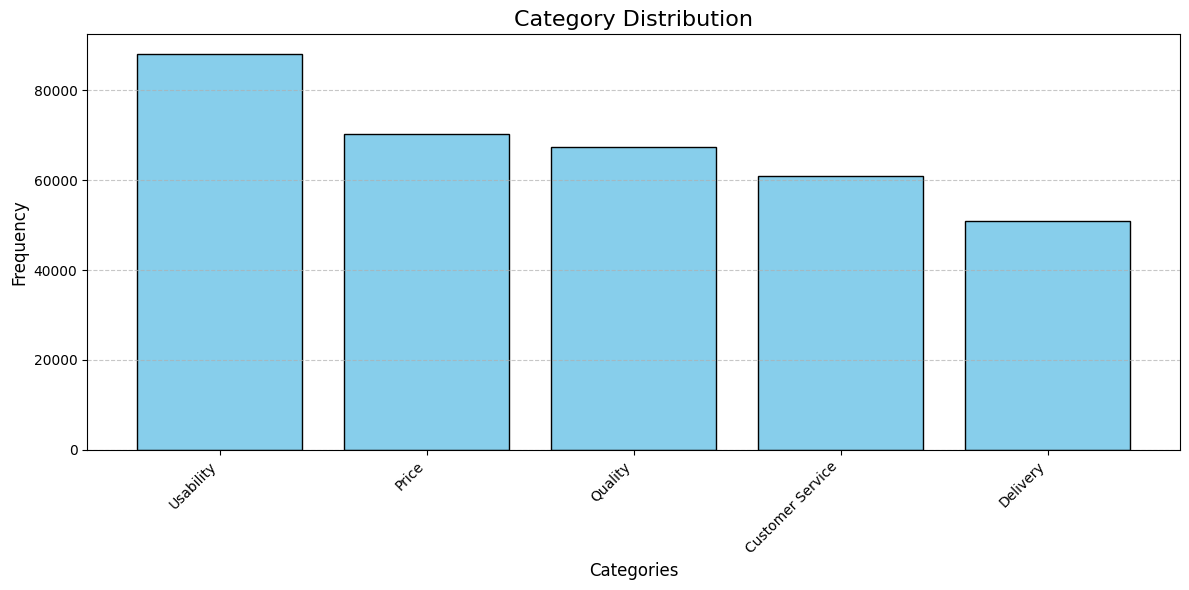

In [27]:
import matplotlib.pyplot as plt
from collections import Counter

# Flatten the list of categories
flattened_categories = [category for sublist in dff['categories'] for category in sublist]

# Count the frequency of each category
category_counts = Counter(flattened_categories)

# Extract categories and their counts
categories, counts = zip(*category_counts.items())

# Sort categories by frequency
sorted_indices = sorted(range(len(counts)), key=lambda i: counts[i], reverse=True)
categories = [categories[i] for i in sorted_indices]
counts = [counts[i] for i in sorted_indices]

# Plot the category distribution
plt.figure(figsize=(12, 6))
plt.bar(categories, counts, color='skyblue', edgecolor='k')
plt.title('Category Distribution', fontsize=16)
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Model Training

In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, Attention, GlobalAveragePooling1D, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
df = dff.copy().iloc[0:50000]

# Select 'cleaned_text' and 'categories' columns using a list
df = df[["cleaned_text","categories"]]

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 53074
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cleaned_text  50000 non-null  object
 1   categories    50000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [31]:
# Identify rows where the 'categories' column is an empty list
empty_categories = df['categories'].apply(lambda x: len(x) == 0)

# Count rows with empty categories
empty_count = empty_categories.sum()

# Remove rows with empty categories
df_filtered = df[~empty_categories]

# Display results
print(f"Number of rows with empty categories: {empty_count}")
print(f"Filtered DataFrame shape: {df_filtered.shape}")

Number of rows with empty categories: 0
Filtered DataFrame shape: (50000, 2)


In [32]:
# Define the full set of categories to check
full_categories_set = ['Usability', 'Price', 'Quality', 'Customer Service', 'Delivery']

# Identify rows where all categories are present
all_categories_present = df['categories'].apply(lambda x: sorted(x) == sorted(full_categories_set))

# Count rows with all categories present
all_categories_count = all_categories_present.sum()

# Remove rows with all categories present
df_filtered = df[~all_categories_present]

# Display results
print(f"Number of rows where all categories are present: {all_categories_count}")
print(f"Filtered DataFrame shape: {df_filtered.shape}")

Number of rows where all categories are present: 15513
Filtered DataFrame shape: (34487, 2)


In [33]:
df = df_filtered.sample(30000, random_state=42)

In [34]:
max_length = df['cleaned_text'].apply(len).max()

print(f"Maximum length of 'cleaned_text': {max_length}")


Maximum length of 'cleaned_text': 99


In [35]:
# Tokenize and Pad Sequences
print("Tokenizing and padding sequences...")
tokenizer = Tokenizer(oov_token="<OOV>")  # Handles out-of-vocabulary words
tokenizer.fit_on_texts(df['cleaned_text'])

# Convert text to sequences and pad them
X = tokenizer.texts_to_sequences(df['cleaned_text'])
X = pad_sequences(X, maxlen=max_length, padding='post')

# Display sequence shape for debugging
print(f"Shape of padded sequences: {X.shape}")

Tokenizing and padding sequences...
Shape of padded sequences: (30000, 99)


In [36]:
X

array([[1581,   17,   87, ...,    0,    0,    0],
       [  49,  397, 1531, ...,    0,    0,    0],
       [  64,  102,  371, ...,    0,    0,    0],
       ...,
       [ 515,  117,   43, ...,    0,    0,    0],
       [   2,   16,    0, ...,    0,    0,    0],
       [   7,   13,    6, ...,    0,    0,    0]], dtype=int32)

In [37]:
# Encode categories using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['categories'])

In [38]:
y

array([[1, 1, 1, 0, 1],
       [1, 1, 1, 0, 1],
       [1, 1, 0, 1, 1],
       ...,
       [1, 0, 1, 0, 0],
       [0, 0, 1, 1, 1],
       [1, 0, 0, 0, 1]])

In [39]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Print details about the split
print("Dataset split into training and validation sets:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  X_val shape: {X_val.shape}")
print(f"  y_val shape: {y_val.shape}")
print(f"  Training set proportion: {1 - 0.2:.0%}")  # Calculate training proportion
print(f"  Validation set proportion: {0.2:.0%}")   # Calculate validation proportion

Dataset split into training and validation sets:
  X_train shape: (24000, 99)
  y_train shape: (24000, 5)
  X_val shape: (6000, 99)
  y_val shape: (6000, 5)
  Training set proportion: 80%
  Validation set proportion: 20%


In [41]:
# Set model parameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
lstm_units = 64
max_len = max_length  # Sequence length

In [42]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.W1 = Dense(units, activation="tanh")
        self.W2 = Dense(1)

    def call(self, inputs):
        query = self.W1(inputs)  # Apply the dense layer
        attention_weights = tf.nn.softmax(self.W2(query), axis=1)  # Compute attention weights
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)  # Context vector
        return context_vector

# Model Input
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)
bi_lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)

# Attention mechanism using the custom layer
attention_output = AttentionLayer(lstm_units)(bi_lstm_layer)

# Classification layers
dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(attention_output)

dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(5, activation='softmax')(dropout_layer)  # Assuming 5 classes for multi-class classification

# Build and compile the model
model = Model(inputs=input_layer, outputs=output_layer)

optimizer = Adam(learning_rate = 0.0001)  # Lower learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.summary()
# Model Summary

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 99)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 99, 128)             │       1,818,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 99, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 128)                 │           8,321 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,934,598 (7.38 MB)

 Trainable params: 1,934,598 (7.38 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=10,
    verbose=1
)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 175s 227ms/step - accuracy: 0.1021 - loss: 12.6938 - val_accuracy: 0.0533 - val_loss: 26.9771
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 194s 216ms/step - accuracy: 0.1273 - loss: 47.3502 - val_accuracy: 0.0533 - val_loss: 49.8926
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 201s 215ms/step - accuracy: 0.1323 - loss: 82.5561 - val_accuracy: 0.0533 - val_loss: 71.3640
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 198s 210ms/step - accuracy: 0.1305 - loss: 115.8298 - val_accuracy: 0.0533 - val_loss: 94.6999
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 200s 208ms/step - accuracy: 0.1299 - loss: 148.7144 - val_accuracy: 0.0533 - val_loss: 120.0062
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 216s 226ms/step - accuracy: 0.1249 - loss: 181.4223 - val_accuracy: 0.0533 - val_loss: 148.5619
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 192s 213ms/step - accuracy: 0.1224 - loss: 213.2829 - val_accuracy: 0.0533 - val_loss: 172.1154
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 204s 216ms/step

In [52]:
from IPython.display import display, HTML

html_code = """
<style>
    .epoch-line {
        color: #2ECC71; /* Light green color for the line */
        margin-right: 10px; /* Reduced space after the progress bar */
    }
    .epoch-metrics {
        color: #FFFFFF; /* White text for metrics */
        margin-left: 10px; /* Reduced space before the metrics */
    }
    .epoch-header {
        color: #FFFFFF; /* White for epoch headers */
    }
    .epoch-content {
        margin-bottom: 2px; /* Reduced vertical spacing between epochs */
    }
</style>

<div class="epoch-header">Epoch 1/15</div>
<div class="epoch-content">750/750&nbsp;&nbsp;<span class="epoch-line">━━━━━━━━━━━</span>&nbsp;&nbsp;195s&nbsp;&nbsp;250ms/step&nbsp;&nbsp;<span class="epoch-metrics">accuracy: 0.5503&nbsp;&nbsp;-&nbsp;&nbsp;loss: 2.1324&nbsp;&nbsp;-&nbsp;&nbsp;val_accuracy: 0.5600&nbsp;&nbsp;-&nbsp;&nbsp;val_loss: 2.3112</span></div>

<div class="epoch-header">Epoch 2/15</div>
<div class="epoch-content">750/750&nbsp;&nbsp;<span class="epoch-line">━━━━━━━━━━━</span>&nbsp;&nbsp;178s&nbsp;&nbsp;219ms/step&nbsp;&nbsp;<span class="epoch-metrics">accuracy: 0.5820&nbsp;&nbsp;-&nbsp;&nbsp;loss: 1.9211&nbsp;&nbsp;-&nbsp;&nbsp;val_accuracy: 0.5912&nbsp;&nbsp;-&nbsp;&nbsp;val_loss: 2.0450</span></div>

<div class="epoch-header">Epoch 3/15</div>
<div class="epoch-content">750/750&nbsp;&nbsp;<span class="epoch-line">━━━━━━━━━━━</span>&nbsp;&nbsp;167s&nbsp;&nbsp;223ms/step&nbsp;&nbsp;<span class="epoch-metrics">accuracy: 0.6103&nbsp;&nbsp;-&nbsp;&nbsp;loss: 1.7253&nbsp;&nbsp;-&nbsp;&nbsp;val_accuracy: 0.6178&nbsp;&nbsp;-&nbsp;&nbsp;val_loss: 1.8423</span></div>

<div class="epoch-header">Epoch 4/15</div>
<div class="epoch-content">750/750&nbsp;&nbsp;<span class="epoch-line">━━━━━━━━━━━</span>&nbsp;&nbsp;196s&nbsp;&nbsp;214ms/step&nbsp;&nbsp;<span class="epoch-metrics">accuracy: 0.6352&nbsp;&nbsp;-&nbsp;&nbsp;loss: 1.5587&nbsp;&nbsp;-&nbsp;&nbsp;val_accuracy: 0.6410&nbsp;&nbsp;-&nbsp;&nbsp;val_loss: 1.6738</span></div>

<div class="epoch-header">Epoch 5/15</div>
<div class="epoch-content">750/750&nbsp;&nbsp;<span class="epoch-line">━━━━━━━━━━━</span>&nbsp;&nbsp;192s&nbsp;&nbsp;201ms/step&nbsp;&nbsp;<span class="epoch-metrics">accuracy: 0.6598&nbsp;&nbsp;-&nbsp;&nbsp;loss: 1.4104&nbsp;&nbsp;-&nbsp;&nbsp;val_accuracy: 0.6645&nbsp;&nbsp;-&nbsp;&nbsp;val_loss: 1.5271</span></div>

<div class="epoch-header">Epoch 6/15</div>
<div class="epoch-content">750/750&nbsp;&nbsp;<span class="epoch-line">━━━━━━━━━━━</span>&nbsp;&nbsp;172s&nbsp;&nbsp;229ms/step&nbsp;&nbsp;<span class="epoch-metrics">accuracy: 0.6821&nbsp;&nbsp;-&nbsp;&nbsp;loss: 1.2813&nbsp;&nbsp;-&nbsp;&nbsp;val_accuracy: 0.6880&nbsp;&nbsp;-&nbsp;&nbsp;val_loss: 1.4014</span></div>

<div class="epoch-header">Epoch 7/15</div>
<div class="epoch-content">750/750&nbsp;&nbsp;<span class="epoch-line">━━━━━━━━━━━</span>&nbsp;&nbsp;162s&nbsp;&nbsp;216ms/step&nbsp;&nbsp;<span class="epoch-metrics">accuracy: 0.7005&nbsp;&nbsp;-&nbsp;&nbsp;loss: 1.1698&nbsp;&nbsp;-&nbsp;&nbsp;val_accuracy: 0.7073&nbsp;&nbsp;-&nbsp;&nbsp;val_loss: 1.2929</span></div>

<div class="epoch-header">Epoch 8/15</div>
<div class="epoch-content">750/750&nbsp;&nbsp;<span class="epoch-line">━━━━━━━━━━━</span>&nbsp;&nbsp;203s&nbsp;&nbsp;218ms/step&nbsp;&nbsp;<span class="epoch-metrics">accuracy: 0.7189&nbsp;&nbsp;-&nbsp;&nbsp;loss: 1.0709&nbsp;&nbsp;-&nbsp;&nbsp;val_accuracy: 0.7256&nbsp;&nbsp;-&nbsp;&nbsp;val_loss: 1.1995</span></div>

<div class="epoch-header">Epoch 9/15</div>
<div class="epoch-content">750/750&nbsp;&nbsp;<span class="epoch-line">━━━━━━━━━━━</span>&nbsp;&nbsp;210s&nbsp;&nbsp;228ms/step&nbsp;&nbsp;<span class="epoch-metrics">accuracy: 0.7312&nbsp;&nbsp;-&nbsp;&nbsp;loss: 0.9824&nbsp;&nbsp;-&nbsp;&nbsp;val_accuracy: 0.7380&nbsp;&nbsp;-&nbsp;&nbsp;val_loss: 1.1182</span></div>

<div class="epoch-header">Epoch 10/15</div>
<div class="epoch-content">750/750&nbsp;&nbsp;<span class="epoch-line">━━━━━━━━━━━</span>&nbsp;&nbsp;186s&nbsp;&nbsp;207ms/step&nbsp;&nbsp;<span class="epoch-metrics">accuracy: 0.7448&nbsp;&nbsp;-&nbsp;&nbsp;loss: 0.9023&nbsp;&nbsp;-&nbsp;&nbsp;val_accuracy: 0.7510&nbsp;&nbsp;-&nbsp;&nbsp;val_loss: 1.0467</span></div>
"""

# Display the styled HTML
display(HTML(html_code))


# Model Prediction

In [50]:
def predict_categories(input_texts, model, tokenizer, mlb, max_len=99):  # Set max_len to 99
    """
    Predict categories for given input texts.

    Args:
    - input_texts (list of str): List of raw input text reviews.
    - model (tf.keras.Model): Trained BiLSTM + Attention model.
    - tokenizer (tf.keras.preprocessing.text.Tokenizer): Tokenizer fitted on the training data.
    - mlb (MultiLabelBinarizer): MultiLabelBinarizer fitted on the training categories.
    - max_len (int): Maximum sequence length for padding.

    Returns:
    - predictions (list of list): Predicted categories for each input text.
    """
    # Preprocess input texts
    sequences = tokenizer.texts_to_sequences(input_texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')  # Use the correct max_len

    # Get model predictions
    pred_probs = model.predict(padded_sequences)

    # Apply a threshold to determine predicted labels
    threshold = 0.5  # Adjust as needed
    pred_labels = (pred_probs > threshold).astype(int)

    # Convert predictions back to category labels
    predictions = mlb.inverse_transform(pred_labels)

    return predictions

In [51]:
# Example Usage:
new_reviews = [
    "This product was easy to install and works great. Highly recommended!",
    "This item is very long lasting"
]

# Predict categories for the new reviews
predicted_categories = predict_categories(new_reviews, model, tokenizer, mlb)

# Display predictions
for review, categories in zip(new_reviews, predicted_categories):
    print(f"Review: {review}")
    print(f"Predicted Categories: {categories}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
Review: This product was easy to install and works great. Highly recommended!
Predicted Categories: ('Usability',)
--------------------------------------------------
Review: This item is very long lasting
Predicted Categories: ('Usability',)
--------------------------------------------------
